# Exploratory Data Analysis

## Proposal Amendment

Before diving into the Exploratory Data Analysis, I'd like to make an amendment to my proposal, slightly altering and then narrowing down the details of my project.

### Questions
- Stellar Flares Question: *Can we estimate the energy emitted by a flare?*
- My Question: *Can we identify whether a given point on a PDCSAP time series is a part of a flare?*

### Methods
- **Pre-treatment:** ARIMA model imputation of missing values + Detrending

**ARIMA models** are classic time series models, fitted according to the autocorrelation between values across time. Their forecasts provide a simple, robust method for imputing missing values. **Detrending** methods (e.g. backfitting, STL, etc.) will help reduce the variation that needs to be accounted for by the model, hopefully improving their predictions. However, it is possible that excessive detrending might absorb lower energy flares.

- **Model:** Isolation Forest (IF) + Time-dependent Cross-Validation (CV)

**Isolation Forests** refer to a tree-based method specialized for outlier detection. They are non-parametric and do not require labelled data. They may be less sensitive to low energy flares, but this might be improved with some feature engineering (e.g. rollign mean, standard deviation, first derivative, etc.). **Time-dependent CV** methods will help with hyperparameter tuning while respecting autocorrelation between observations.

- **Model evaluation:** Flare simulation + Baseline model comparison

**Simulating flares** in a real PDCSAP time series will provide a controlled setting with which the model can be evaluated. Varying the parameters of the simulated flares will further allow for estimation of the model sensitivity, especially valuable to observe with respect to flare intensity. **Baseline models** like sigma-clipping/Z-score methods will provide a benchmark for our model.

- **Exploration:** IF Anomaly Scores

**IF anomaly scores** provide a continuous response rather than binary classification of points as flare/no flare, akin to soft vs. hard labelling. This could be used to define a "flare confidence threshold" using the relative values of anomaly scores in the area surrounding observations above the classifiation threshold.

**********DELETE ME********************


Ideas:
- ARIMA model - with detrending included
    - STL with loess
- ML model - Unsupervised - Isolation tree, KNN
    - With cross validation
- ML model - Supervised - Simulate flares --> traing XGboost on simulated flares, run on real data...?
    - Not guaranteed to work well on real data though - could compare against other models...

- Create a plot, where each observation is coloured as a gradient of how likely it is part of a flare.
    - Then, can create a plot where observations classified as flares are highlighted, with sort of "credible intervals" placed on them, including all adjacent observations with higher probabilities.

**Notes - OH Arturo:**
- Mention pros/cons of model
- Autocorrelated CV - control for lags
- Cite reputable sources when doing things
    - Comment on any issues you notice

## Exploratory Data Analysis

For this project, we will focus on the M dwarf TIC 031381302, as done with the related paper. The date ranges analyzed in the paper are different, but this will give us a benchmark for our model.

To get familiar with the data, we will load it using pandas library, get a distribution of values, take a look at the time series as a whole, and then start looking at patterns in the data.

In [2]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
## Data
df = pd.read_csv("../0.Data/031381302.csv")

# Check
print(df.shape)
#df.head()
#random.seed(2453)
#df.loc[random.sample(range(df.shape[0]), 1) + np.arange(0, 5)]
df.info()

(17719, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17719 entries, 0 to 17718
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             17719 non-null  float64
 1   flux             17033 non-null  float64
 2   flux_err         17033 non-null  float64
 3   timecorr         17719 non-null  float64
 4   cadenceno        17719 non-null  int64  
 5   centroid_col     17649 non-null  float64
 6   centroid_row     17649 non-null  float64
 7   sap_flux         17649 non-null  float64
 8   sap_flux_err     17649 non-null  float64
 9   sap_bkg          17649 non-null  float64
 10  sap_bkg_err      17649 non-null  float64
 11  pdcsap_flux      17033 non-null  float64
 12  pdcsap_flux_err  17033 non-null  float64
 13  quality          17719 non-null  int64  
 14  psf_centr1       0 non-null      float64
 15  psf_centr1_err   0 non-null      float64
 16  psf_centr2       0 non-null      float64
 17  

In [4]:
## Time Series of interest
pdcsap = df.loc[:, ["time", "pdcsap_flux"]]

# Check
print(pdcsap.shape); pdcsap.info(); pdcsap.head()

(17719, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17719 entries, 0 to 17718
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         17719 non-null  float64
 1   pdcsap_flux  17033 non-null  float64
dtypes: float64(2)
memory usage: 277.0 KB


,time,pdcsap_flux
0,1437.978646,NaN
1,1437.980034,NaN
2,1437.981423,NaN
3,1437.982812,NaN
4,1437.984201,NaN


In [5]:
## NaNs/Nulls
nulls = pdcsap.isnull().sum()
print(nulls)
#print([nulls, pdcsap.shape[0]*pdcsap.shape[1] - nulls])
# Time
#nans = pdcsap["time"].isna().sum()
print([nulls[0], pdcsap.shape[0] - nulls[0]])
# PDCSAP flux
#nans = pdcsap["pdcsap_flux"].isna().sum()
print([nulls[1], pdcsap.shape[0] - nulls[1]])

# Impute missing values (temporary)
# pdcsap_mod: Modified pdcsap_flux by imputing them with the mean (temporary).
pdcsap["pdcsap_mod"] = pdcsap["pdcsap_flux"]
pdcsap.fillna(pdcsap["pdcsap_mod"].mean(), inplace=True)

time             0
pdcsap_flux    686
dtype: int64
[0, 17719]
[686, 17033]


### Comments

Thankfully, there are no missing time values, but there seem to be nearly 700 missing flux values. During pre-treatment, we will need to explore whether we can avoid imputing them. If imputation is needed, we could utilize a trend-based forecast, perhaps an ARIMA model.

## Distribution

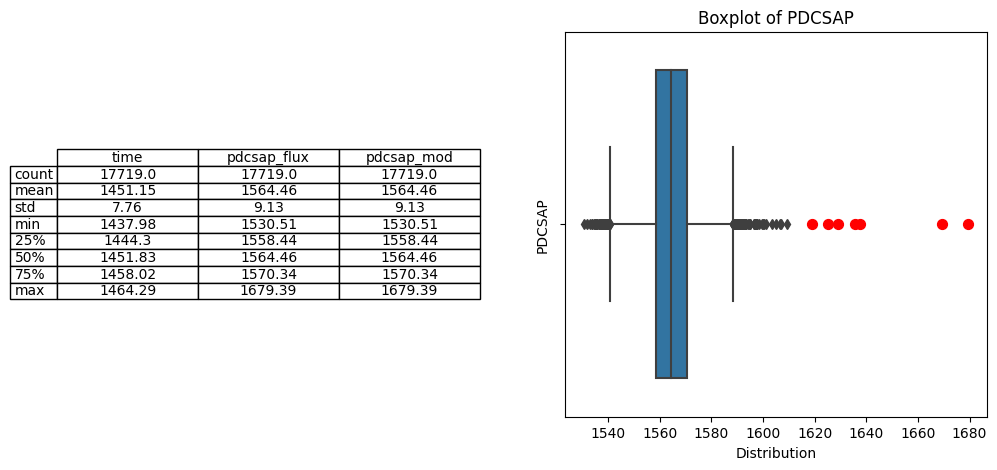

In [6]:
## Distribution
# Summary statistics
#print(pdcsap.describe())
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns
# Summary statistics
summary_stats = np.round(pdcsap.describe(), 2)
ax[0].table(cellText = summary_stats.values, colLabels = summary_stats.columns, rowLabels = summary_stats.index, cellLoc = "center", loc = "center")
ax[0].axis("off"); ax[0].axis("tight")

# Boxplot
#plt.figure(figsize=(8, 4))
#pdcsap.boxplot(pdcsap)
sns.boxplot(x = pdcsap["pdcsap_flux"])
plt.title("Boxplot of PDCSAP")
plt.ylabel("PDCSAP")
plt.xlabel("Distribution")

# Flag outliers
mean_val = pdcsap["pdcsap_flux"].mean()
std_val = pdcsap["pdcsap_flux"].std()
num_devs = 5
outliers = (pdcsap["pdcsap_flux"] < mean_val - num_devs * std_val) | (pdcsap["pdcsap_flux"] > mean_val + num_devs * std_val)
#outliers_pos = 
#sns.stripplot(x = pdcsap["pdcsap_flux"][outliers], color = "red", size = 6)
#plt.scatter(x = pdcsap["pdcsap_flux"][outliers], y = np.zeros(outliers.shape[0]), color = "red", size = 6)
plt.scatter(pdcsap["pdcsap_flux"][outliers], np.zeros(sum(outliers)), color='red', s=50, zorder=3)

plt.show()

### Comments

Normal sigma-clipping models would begin by performing detrending and then classifying consecutive observations outside a certain number of standard deviations as flares. I assume that first step would reduce the variation seen in the above boxplot, leaving some of the greater outliers to the right, perhaps flagging those identified in red.

## Holistic View: PDCSAP flux over Time

In [7]:
## Set "time" as index
pdcsap.set_index("time", inplace=True)

# Check
print(pdcsap.shape); pdcsap.info(); pdcsap.head()

(17719, 2)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17719 non-null  float64
 1   pdcsap_mod   17719 non-null  float64
dtypes: float64(2)
memory usage: 415.3 KB


,pdcsap_flux,pdcsap_mod
time,,
1437.978646,1564.459684,1564.459684
1437.980034,1564.459684,1564.459684
1437.981423,1564.459684,1564.459684
1437.982812,1564.459684,1564.459684
1437.984201,1564.459684,1564.459684


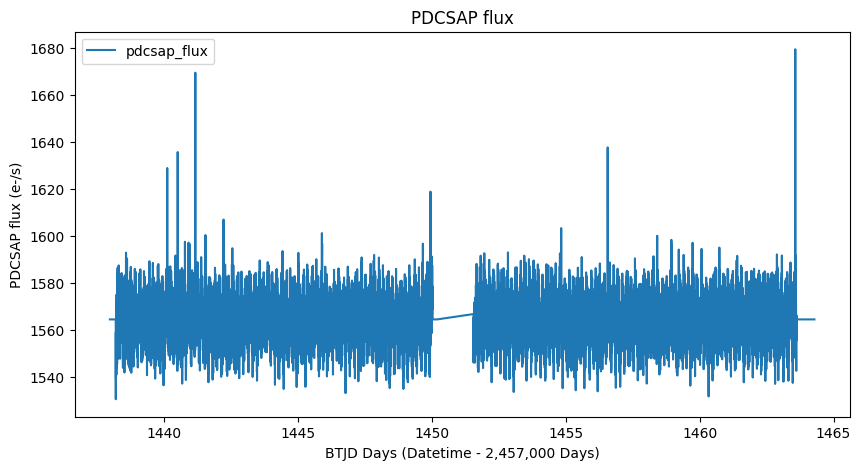

In [8]:
## Holistic plot of the time series
# Line Plot
pdcsap.plot(y = "pdcsap_flux", title = "PDCSAP flux", figsize = (10, 5))
plt.xlabel("BTJD Days (Datetime - 2,457,000 Days)")
plt.ylabel("PDCSAP flux (e-/s)")

plt.show()

The date range of 1438-1442 looks interesting, let's zoom in for a better look.

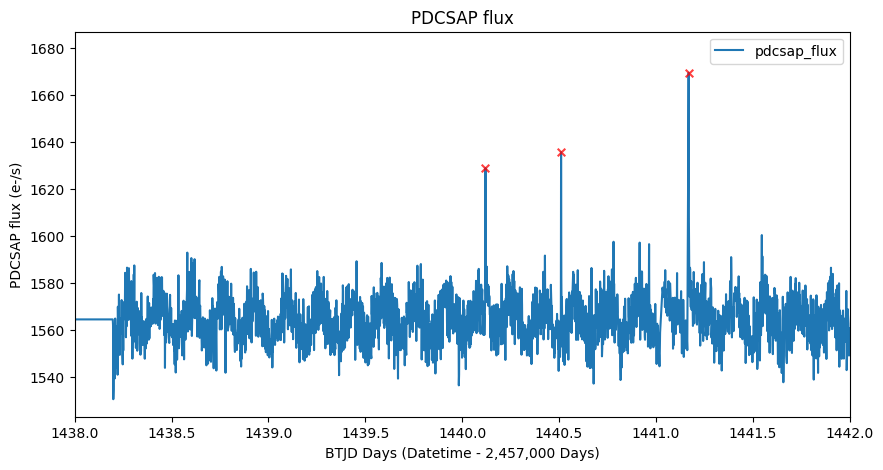

In [9]:
## Zoom in
# Plot
pdcsap.query("1438 <= index <= 1442").plot(y = "pdcsap_flux", title = "PDCSAP flux", figsize = (10, 5))
plt.xlabel("BTJD Days (Datetime - 2,457,000 Days)")
plt.ylabel("PDCSAP flux (e-/s)")
plt.xlim([1438, 1442])

# Flag outliers
num_devs = 5
outliers = (pdcsap["pdcsap_flux"] < mean_val - num_devs * std_val) | (pdcsap["pdcsap_flux"] > mean_val + num_devs * std_val)
plt.scatter(x = pdcsap.index[outliers], y = pdcsap["pdcsap_flux"][outliers], color='red', s=30, zorder=3, marker="x", alpha = 0.75)

plt.show()

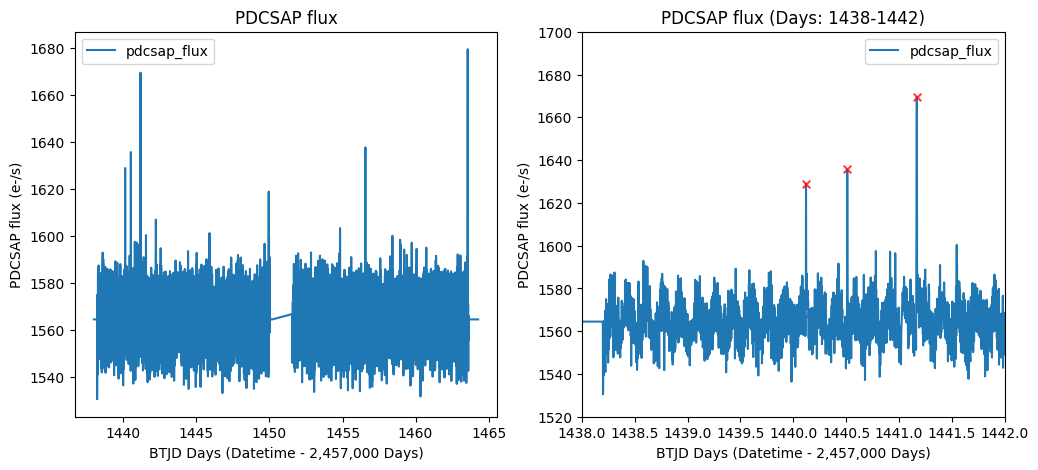

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

## Holistic plot of the time series
# Line Plot
pdcsap.plot(y = "pdcsap_flux", title = "PDCSAP flux", ax = ax[0])
ax[0].set_xlabel("BTJD Days (Datetime - 2,457,000 Days)")
ax[0].set_ylabel("PDCSAP flux (e-/s)")

## Zoom in
# Plot
pdcsap.query("1438 <= index <= 1442").plot(y = "pdcsap_flux", title = "PDCSAP flux (Days: 1438-1442)", ax = ax[1])
ax[1].set_xlabel("BTJD Days (Datetime - 2,457,000 Days)")
ax[1].set_ylabel("PDCSAP flux (e-/s)")
ax[1].set_xlim([1438, 1442])
ax[1].set_ylim([1520, 1700])

# Flag outliers
num_devs = 5
outliers = (pdcsap["pdcsap_flux"] < mean_val - num_devs * std_val) | (pdcsap["pdcsap_flux"] > mean_val + num_devs * std_val)
ax[1].scatter(x = pdcsap.index[outliers], y = pdcsap["pdcsap_flux"][outliers], color='red', s=30, zorder=3, marker="x", alpha = 0.75)

plt.show()

In [11]:
#pdcsap[(pdcsap["time"] <= 1442) & (pdcsap["time"] >= 1438)]
#pdcsap.query("1438 <= index <= 1442")
#pdcsap.index

### Comments

Immediately, we can see that there are some larger spikes in the data, flagged in red, as well as some smaller spikes in between, any or all of which could very well correspond to flares. Additionally, there is clearly some sort of oscillating pattern appearing to occur roughly 3 times a day.

## Autocorrelation and Frequency

The time series does not appear to be white noise, but it may or may not have consistent behaviour over time, i.e. stationarity. To check this, we apply the Augmented Dickey-Fuller (ADF) unit root test, where $H_0:$ non-stationary (integrated), meaning the time series would be inconsistent over time.

In [12]:
## Stationarity
# ADF
from statsmodels.tsa.stattools import adfuller

result = adfuller(pdcsap["pdcsap_flux"].dropna())
#print(result)
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Statistic: -30.346393685302296
P-value: 0.0


### Comments

Interestingly, the Augemented Dickey-Fuller (ADF) test returns a negative test statistic and a very small p-value. This provides evidence against $H_0$, that the time series is non-stationary. In other words, it suggests that the time series is stationary, having consistent behaviour over time.

=======As expected, this provides evidence against the time series being stationary. Hence, it is an integrated time series, i.e. it is not white noise.

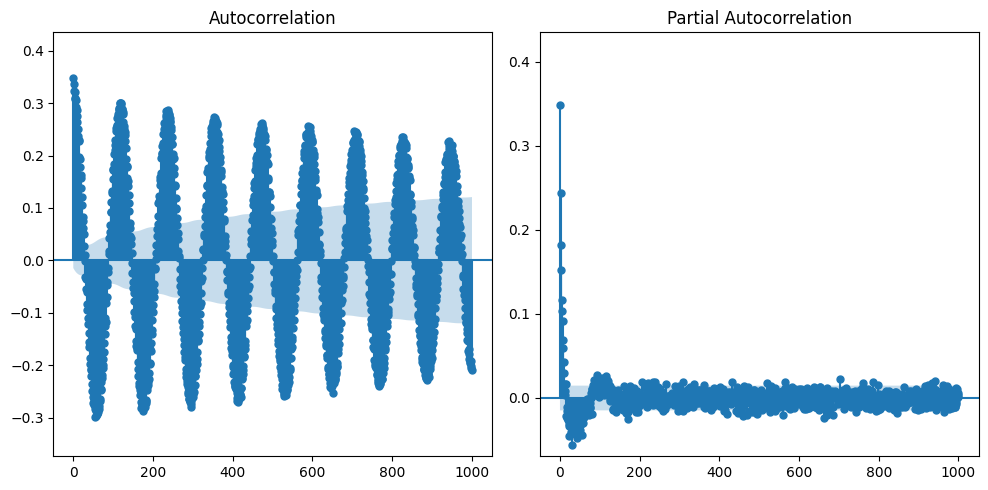

In [ ]:
# Autocorrelation
#import statsmodels.api as sm
#pd.plotting.autocorrelation_plot()
#sm.graphics.tsa.plot_acf(pdcsap['pdcsap_flux'], lags = 30, auto_ylims=True)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns
plot_acf(pdcsap["pdcsap_flux"], lags = 1000, ax = ax[0], auto_ylims = True, zero = False)
plot_pacf(pdcsap["pdcsap_flux"], lags = 1000, ax = ax[1], method = "ywm", auto_ylims = True, zero = False)

plt.tight_layout()
plt.show()

In [21]:
pdcsap.shape
np.log(pdcsap.shape[0])
np.sqrt(pdcsap.shape[0])
pdcsap.shape[0]/4

4429.75

In [ ]:
## Partial Autocorrelation
#sm.graphics.tsa.plot_pacf(pdcsap['pdcsap_flux'], lags = 30, method = 'ywm')

#plt.show()

### Comments

In the autocorrelation plot above, we see a gradual decline over time (lags). This slow decline suggests the presence of a long-term dependence structure. If we were using an ARIMA model, this would suggest the presence of a moving average (MA) component. The partial autocorrelation plot on the right also shows a gradual decline, suggesting the presence of an autoregressive (AR) component. Hence, an ARMA model might be applicable here. This could be useful for imputing missing values.

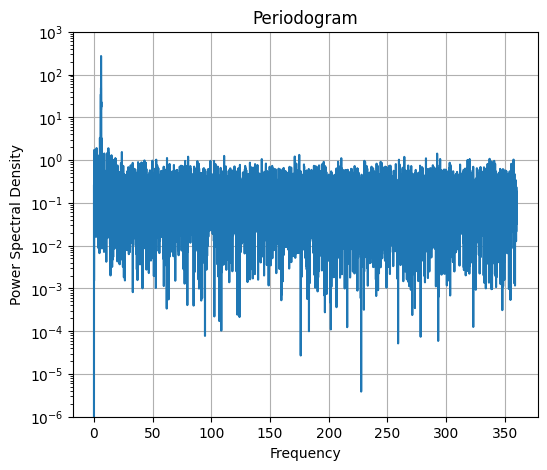

In [82]:
## Periodogram
from scipy.signal import periodogram
freq, power_spectral_density = periodogram(pdcsap['pdcsap_flux'], fs = 720)

# Plot
plt.figure(figsize=(6, 5))
plt.semilogy(freq, power_spectral_density)  # Log scale for better visualization
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.grid(True)
#plt.ylim([10**(-3), 10**5])
plt.ylim([10**(-6), 10**3])

plt.show()

### Comments

In the periodogram, the most noticable peaks occur at low frequencies, suggesting the presence of a long-term trend or low-frequency variations. Based on the ADF test and autocorrelation plots, I'd lean towards the latter. However, the lack of sharp periodic peaks suggests no clearly evident cyclical behaviour, which also appears visible in our earlier line plot.

In [ ]:
## STL
from statsmodels.tsa.seasonal import seasonal_decompose

# Frequency
ts_freq = pdcsap.query("1445 <= time < 1446").count()
print(ts_freq)
num_cycles = 3

decomposition = seasonal_decompose(pdcsap["pdcsap_flux"], model="additive", period = round(ts_freq[0]/num_cycles))

#plt.figure(figsize = (8, 6))
decomposition.plot()

plt.show()

240.0


<Figure size 600x500 with 0 Axes>

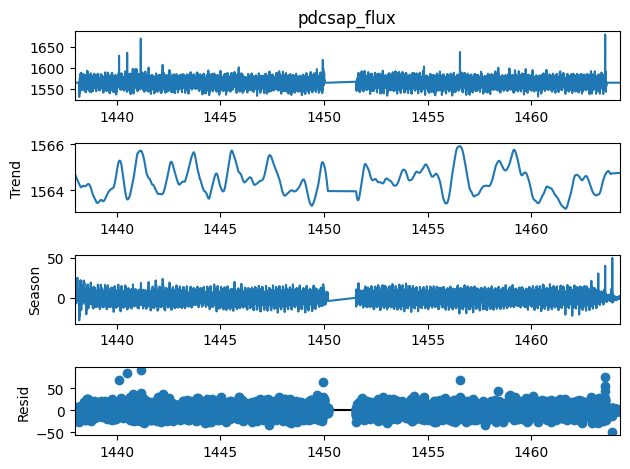

In [85]:
## STL
from statsmodels.tsa.seasonal import STL

# Frequency
num_cycles = 3
ts_freq = pdcsap.query("1445 <= time < 1446").count()
season_period = ts_freq[0]/num_cycles
print(season_period)

stl = STL(pdcsap["pdcsap_flux"], period = round(season_period), robust = True)
result = stl.fit()

# Plot
plt.figure(figsize = (6, 5))
result.plot()

plt.show()

### Comments

Based on the above STL decomposition, the seasonal copmponent appears to capture repeating patterns over the 240-observation period. This warrants further investigation during model building. The trend component appears smooth, indicating a potential underlying trend. However, given the periodogram, I'd lean towards these being low-frequency variations. Lastly, there appear to be outliers in the residuals. These could very well reflect some of the medium-high energy flares flagged earlier.

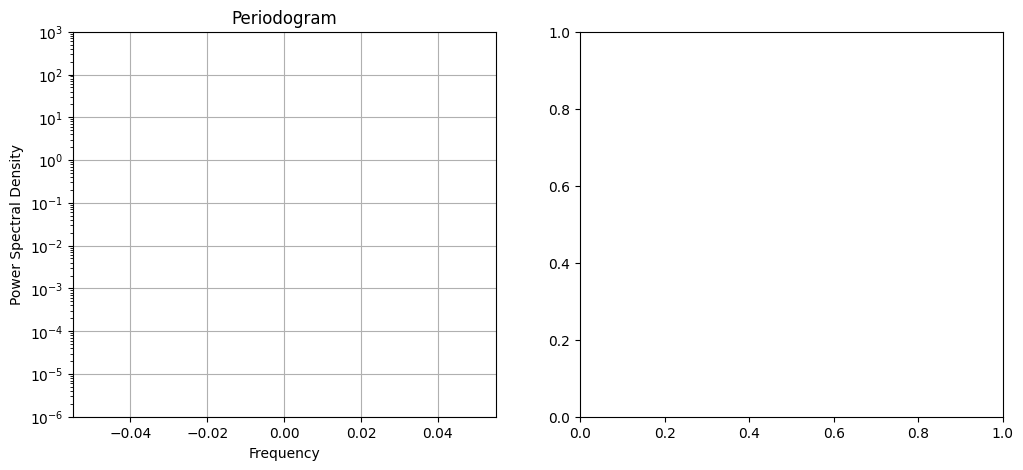

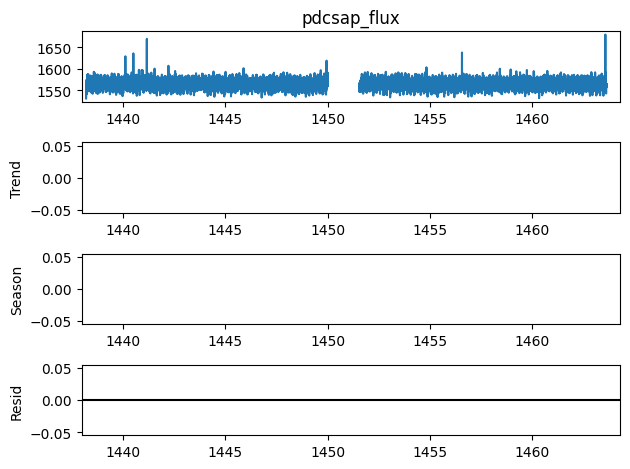

In [39]:
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL

# Create figure with 2 side-by-side subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

## Periodogram
freq, power_spectral_density = periodogram(pdcsap['pdcsap_flux'], fs=720)

# Plot Periodogram in first subplot
ax[0].semilogy(freq, power_spectral_density)  # Log scale for better visualization
ax[0].set_title("Periodogram")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Power Spectral Density")
ax[0].grid(True)
ax[0].set_ylim([10**(-6), 10**3])  # Adjust Y-limits

## STL Decomposition
num_cycles = 3
ts_freq = pdcsap.query("1445 <= time < 1446").count()
season_period = ts_freq[0] / num_cycles

stl = STL(pdcsap["pdcsap_flux"], period=round(season_period), robust=True)
result = stl.fit()

# Plot STL decomposition in second subplot
result.plot()#ax=ax[1])  

#plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


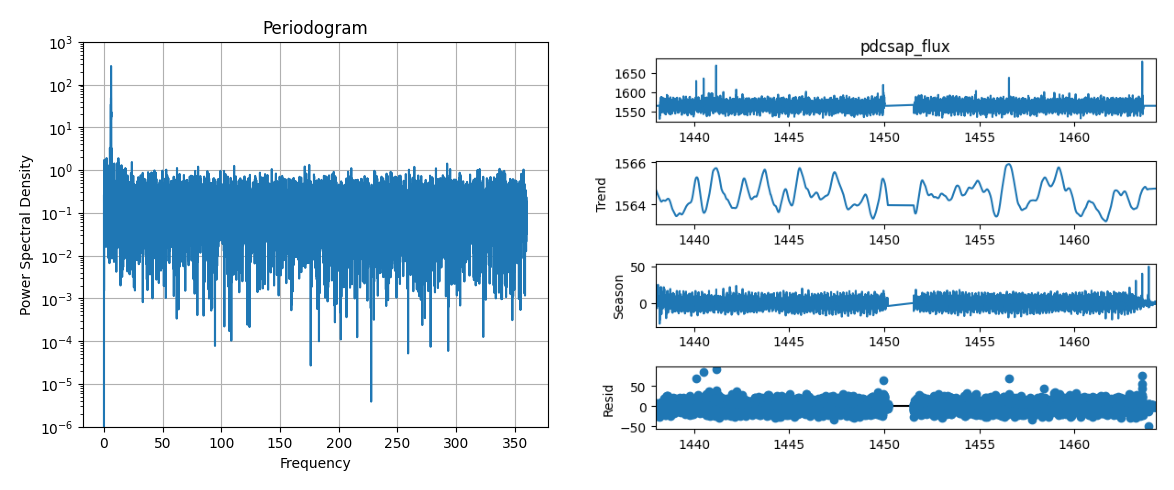

In [86]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the uploaded image
#image_path = "/mnt/data/image.png"  # Using the uploaded image file
image1 = mpimg.imread("../1.Figures/EDA_periodogram.png")
image2 = mpimg.imread("../1.Figures/EDA_STL.png")

# Create side-by-side subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Display images in subplots
ax[0].imshow(image1)
ax[0].axis("off")  # Hide axes
#ax[0].set_title("Image 1")

ax[1].imshow(image2)
ax[1].axis("off")  # Hide axes
#ax[1].set_title("Image 2")

plt.tight_layout()
plt.show()
